# AMI JWST Phase Retrieval on Simulated Data
In this notebook we will generate some fake AMI data and fit to it. The free parameters used in this model will be:
- Source Flux
- $7 \times 6$ Hexike coefficients
- $(x, y)$ Source Position [under development]
- 7 or so 2ndary mirror aberrations [not implemented error]

Importing relevant packages

In [1]:
import webbpsf
import dLux as dl
import dLuxWebbpsf as dlW

import jax.numpy as np
import jax.random as jr

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import optax
import zodiax as zdx
import jax

from dLux.utils import deg_to_rad as d2r
from optics import _construct_optics
from detector_layers import DistortionFromSiaf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


## Building NIRISS model

In [2]:
# Primary mirror - note this class automatically flips about the y-axis
webbpsfobj = webbpsf.NIRISS()
webbpsfobj.calc_psf()  # calculating fits files
webbpsfobj.pupil_mask = "MASK_NRM"
NIS_CEN_aperture = webbpsfobj.siaf.apertures["NIS_CEN"]
webbpsf_osys = webbpsfobj.get_optical_system()
planes = webbpsf_osys.planes

In [3]:
true_flux = 1e6
true_coeffs = coefficients = 2e-7 * jr.normal(jr.PRNGKey(0), (7, 6))

In [4]:
osys = _construct_optics(
    planes=planes,
    instrument=webbpsfobj,
    wf_npix=1024,
    oversample=4,
    radial_orders=[0, 1, 2],
    coefficients=np.array(coefficients),
    AMI=True,
)

src = dl.PointSource(flux=true_flux, **dict(np.load("filter_configs/F480M.npz")))
detector = dl.LayeredDetector(
    [
        dlW.detector_layers.Rotate(-d2r(getattr(NIS_CEN_aperture, "V3IdlYAngle"))),
        DistortionFromSiaf(
            aperture=NIS_CEN_aperture
        ),  # TODO implement dLuxWebbpsf version
        dl.IntegerDownsample(kernel_size=4),  # Downsample to detector pixel scale
    ]
)

instrument = dl.Instrument(sources=[src], detector=detector, optics=osys)

# Simulating fake data
Here we are using a "true" flux value of $10^6$ photons, and all the "true" coefficient values are randomly generated.

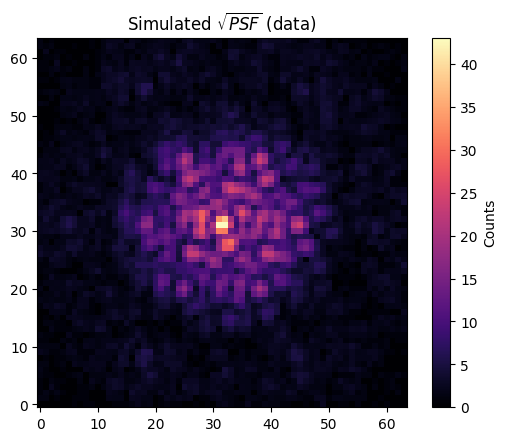

In [23]:
data = jr.poisson(jr.PRNGKey(0), instrument.model())

plt.imshow(data**0.5, cmap='magma')
plt.title('Simulated $\sqrt{PSF}$ (data)')
plt.colorbar(label='Counts')
plt.show()

## Optimisation
Let's define our paths to our parameters inside of the instrument object.

In [6]:
flux_path = 'PointSource.flux'
hexike_path = 'optics.pupil.coefficients'

parameter_paths = [flux_path, hexike_path]

Defining our model to be a copy of the instrument object, with random initial value of flux and all coefficients starting at zero.

In [7]:
# Multiply the fluxes by small random values
model = instrument.multiply(flux_path, 1 + 0.1*jr.normal(jr.PRNGKey(0)))

# Set the zernike coefficients to zero
model = model.set(hexike_path, np.zeros(model.get(hexike_path).shape))

Creating our optimisers using optax - the `adam` algorithm is a gradient descent algorithm with momentum and acceleration terms to avoid falling trap to local minima.

In [8]:
# So first we simply set the simple parameters to use an adam optimiser 
# algorithm, with individual learning rates
flux_optimiser  = optax.adam(5e3, b1=0.8)
coeff_optimiser = optax.adam(5e-8)

# Combine the optimisers into a list
optimisers = [flux_optimiser, coeff_optimiser]

# Generate out optax optimiser, and also get our args
optim, opt_state = zdx.get_optimiser(model, parameter_paths, optimisers)

Defining our loss function and jitting it - this will make the function evaluation much faster in subsequent calls.

In [9]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameter_paths)
def loss_fn(model, data):
    out = model.model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Checking the loss at our initial values.

In [10]:
%%time
loss, grads = loss_fn(model, data) # Compile
print("Initial Loss: {}".format(int(loss)))

Initial Loss: 34293
CPU times: user 4.96 s, sys: 532 ms, total: 5.5 s
Wall time: 3.29 s


Running gradient descent!

In [11]:
losses, models_out = [], []
iters = 200
with tqdm(range(iters),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, data)    
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/200 [00:00<?, ?it/s]

Grabbing the output.

In [12]:
psfs_out = models_out[-1].model()

flux_found     = np.array([model.get(flux_path)    for model in models_out])
hexikes_found   = np.array([model.get(hexike_path)  for model in models_out])

In [13]:
coeff_residuals = true_coeffs - hexikes_found
flux_residuals = true_flux - flux_found

Plotting loss and residuals.

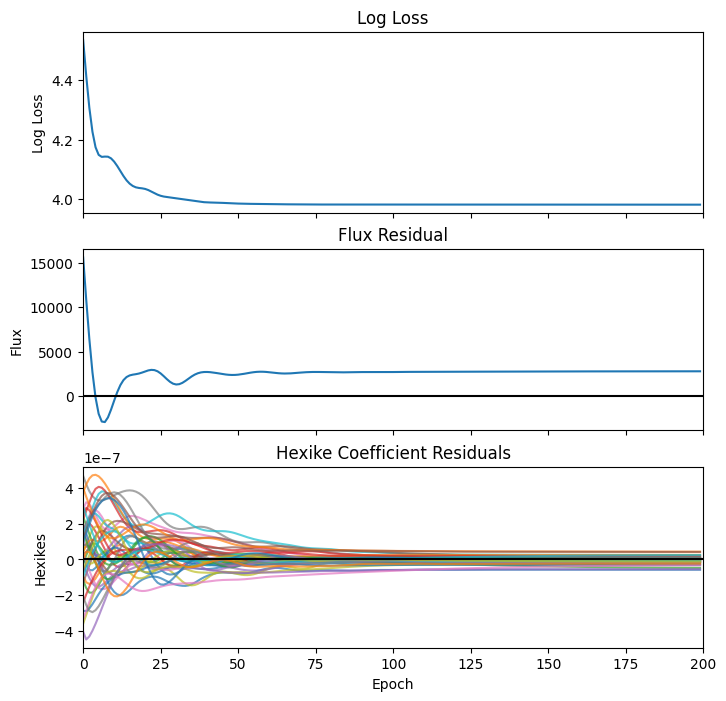

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

ax[0].plot(np.log10(np.array(losses)))
ax[0].set(title='Log Loss', ylabel='Log Loss', xlim=(0, iters))

ax[1].plot(flux_residuals)
ax[1].set(title='Flux Residual', ylabel='Flux')
ax[1].axhline(0, color='k')

ax[2].plot(coeff_residuals.reshape((coeff_residuals.shape[0], coeff_residuals.shape[1]*coeff_residuals.shape[2])), alpha=0.7)
ax[2].set(title='Hexike Coefficient Residuals', xlabel='Epoch', ylabel='Hexikes')
ax[2].axhline(0, color='k')

plt.show()

Checking out the OPD!

In [15]:
true_opd = instrument.pupil.basis_opd
opds_found = np.array([model.pupil.basis_opd for model in models_out])
opd_found = opds_found[-1]
opd_residuals = true_opd - opds_found
opd_rmse_nm = 1e9*np.mean(opd_residuals**2, axis=(-1,-2))**0.5

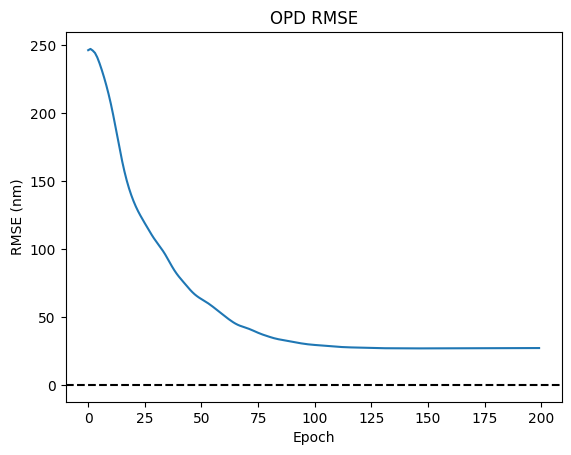

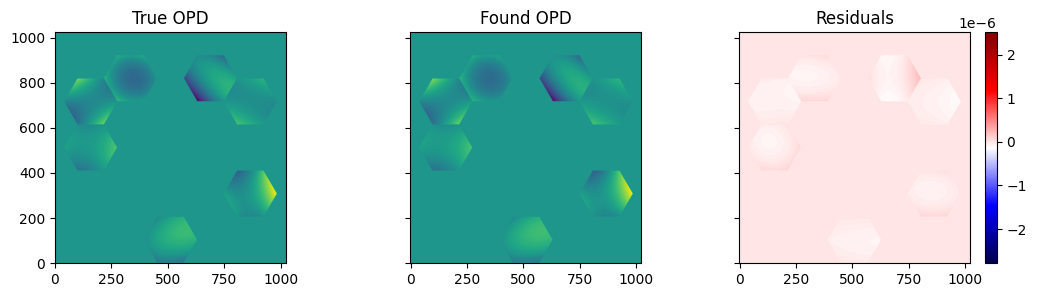

In [16]:
vmin = np.min(np.array([true_opd, opd_found]))
vmax = np.max(np.array([true_opd, opd_found]))

fig, ax = plt.subplots()
ax.plot(opd_rmse_nm)
ax.set(title='OPD RMSE', xlabel='Epoch', ylabel='RMSE (nm)')
ax.axhline(0, color='k', linestyle='--')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(13,3), sharey=True)
ax[0].imshow(true_opd, vmin=vmin, vmax=vmax)
ax[0].set(title='True OPD')

ax[1].imshow(opd_found, vmin=vmin, vmax=vmax)
ax[1].set(title='Found OPD')

c = ax[2].imshow(true_opd - opd_found, vmin=vmin, vmax=vmax, cmap='seismic')
ax[2].set(title='Residuals')
fig.colorbar(c)
plt.show()

Visualising the accuracy of the coefficients (love this plot, thanks Louis)

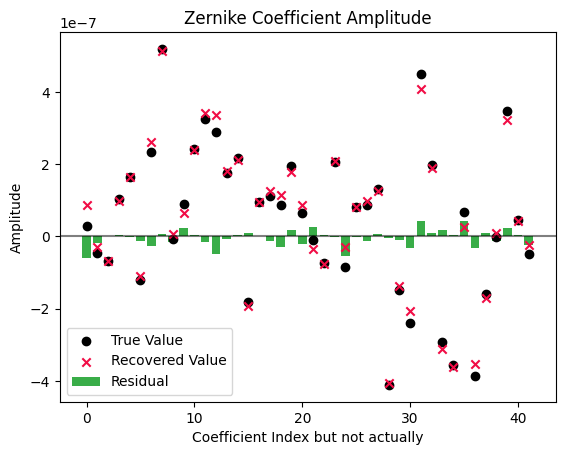

In [17]:
# Coefficients
true_coeff = instrument.get(hexike_path).flatten()
found_coeff = models_out[-1].get(hexike_path).flatten()
index = np.arange(len(true_coeff))

plt.figure()
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("Coefficient Index but not actually")
plt.ylabel("Amplitude")
plt.scatter(index, true_coeff, label="True Value", c='k')
plt.scatter(index, found_coeff, label="Recovered Value", marker='x', c='#f10c45')
plt.bar(index, true_coeff - found_coeff, label='Residual', color='#39ad48', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()

Finally, looking at the PSF residuals.

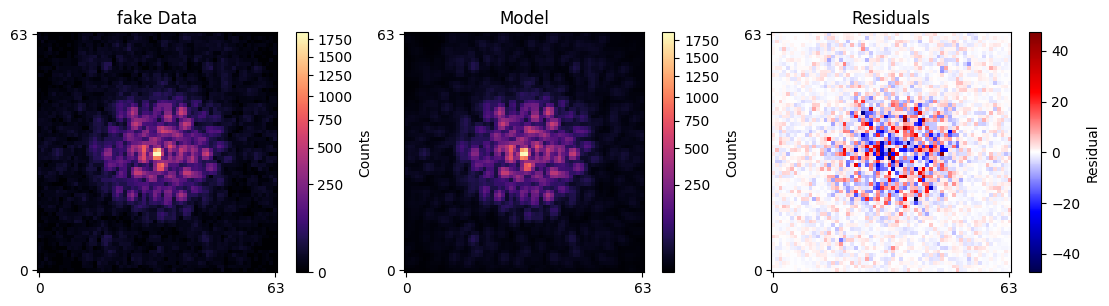

In [18]:
from utils import plot_and_compare
plot_and_compare(data, model.model(), titles=['fake Data', 'Model'], colorbars=True, cbar_label='Counts')